# Spriral Search
At each iteration, we sample noise from a zero-mean Gaussian distribution.
This is then added with the current parameters to produce the new parameters.

For exploration, after each unsuccessful iteration, the deviation of the noise is grown/annealed between certain fixed bounds.
The deviation is reset after each successful iteration.

The best solution is kept.

# Setup

## Imports

In [1]:
import gym

Torch Modules

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
from time import time

In [4]:
from utils.environment import add_energy, make_specs, run_env
from utils.model import get_params, set_params, get_action
from utils.searchers import Searcher

## Define Useful Functions

In [5]:
jtplot_style()

## Load Environment

In [6]:
env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
make_specs(env)
n_obs = env.spec.n_obs
n_act = env.spec.n_act

In [8]:
add_energy(env)

# Create Model

In [9]:
model = nn.Linear(n_obs, n_act)

# Create Searcher

In [10]:
class SprialSearcher(Searcher):
    def __init__(self, model, evaluator, std_range=(-3, 2), std_growth=-2):
        super().__init__(model, evaluator)
        self._std_range = std_range
        self._std_growth = 10 ** std_growth
        self._std = 10 ** std_range[0]
        self._direction = 1
        
    def _new_params(self):
        noise = torch.randn(len(self._params)) * self._std
        return self._params + noise
    
    def _successful(self):
        super()._successful()
        self._std = 10 ** self._std_range[0]
        
    def _unsuccessful(self):
        super()._unsuccessful()
        self._std *= 1 + self._direction * self._std_growth
        print(f'{self._rewards[-1][1]:.2f}, {self._std:.2e}', end='\r')
        
        std_mag = np.log10(self._std)
        is_below = (std_mag < self._std_range[0] and self._direction < 0)
        is_above = (std_mag > self._std_range[1] and self._direction > 0)
        if is_above or is_below: self._direction *= -1

In [11]:
def evaluator(model, gamma=0, episodes=1):
    rewards, energies = run_env(env, lambda x: get_action(model, x), episodes)
    return rewards - gamma * energies

In [12]:
searcher = SprialSearcher(model, lambda x: evaluator(x, gamma=0.0, episodes=5))

# Search

In [13]:
searcher()

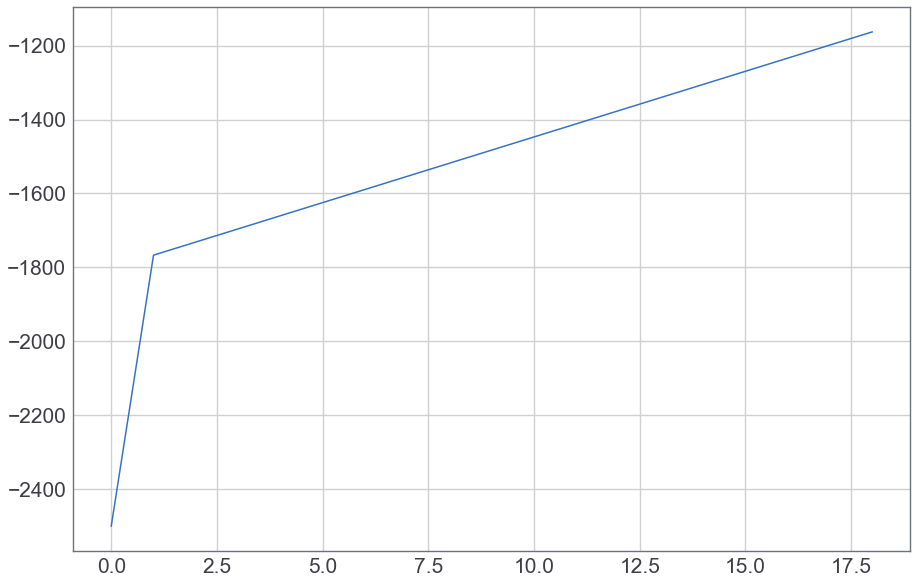

In [14]:
searcher.plot_search()

# Sample Model

In [23]:
run_env(env, lambda x: get_action(model, x, probabilistic=True), 5, render=True)

(-803.0, 0)